In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import swifter
import json
from collections import namedtuple
import re

import itertools
from pprint import pprint


# Functions

In [2]:
# Find files
# This function input the path of experiment directory and output a list of device directories of the experiment directory.
def find_device_under_exp(exp_dir_path):
    dev_dir_list = sorted([os.path.join(exp_dir_path, d) for d in os.listdir(exp_dir_path) if d.startswith('qc') or d.startswith('sm')])
    return dev_dir_list

def find_trace_under_device(dev_dir_path):
    trace_dir_list = sorted([os.path.join(dev_dir_path, d) for d in os.listdir(dev_dir_path)])
    return trace_dir_list


# Convenience instance
class EXPERIMENT():
    def __init__(self, exp_dir_path, settings):
        self.path = exp_dir_path
        self.settings = json.loads(settings)
    def __repr__(self):
        return f'EXP: {self.path} -> {self.settings}'

In [3]:
def parse_mi_ho(f):

    df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8)) 
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.end).total_seconds(), target, ho))

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None

    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }
    
    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        try: lte_pci, lte_earfcn
        except: 
            lte_pci = df["PCI"].iloc[i]
            lte_earfcn = int(df["Freq"].iloc[i])

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
        
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            _, idx = find_1st_after(i, 'ueCapabilityInformation',look_after=1)
            if idx is not None:
                sup_band = df['bandEUTRA'].iloc[idx]
                others += f' supported band: {sup_band}.' 

            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'({lte_pci}, {lte_earfcn}) -> ({serv_cell}, {serv_freq})'
            
            # Check if caused by RLF III.
            a, idx = find_1st_before(i, 'rrcConnectionReestablishmentReject', look_before=1)
            if a is not None:
                others += ' After RLF III.'

            D['Conn_Req'].append(HO(start=t,end=end,trans=trans, others=others))

            nr_pci = 'O'
            lte_pci = serv_cell
            lte_earfcn = serv_freq
            
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            lte_pci = target_cell
            lte_earfcn = target_freq

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        others += f' Near after RLF of trans: {ho.trans}.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    ori_serv = nr_pci
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {ori_serv} -> {nr_pci}'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = nr_pci
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = nr_pci
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = nr_pci
            nr_pci = int(df['nr_physCellId'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

                lte_pci = serv_cell
                lte_earfcn = serv_freq

            elif b is not None and end2 is not None:
                
                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans)) 

                # lte_pci, lte_earfcn will be updated in rrcConnectionRequest.     
                
            else:

                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                trans = f'({serv_cell}, {serv_freq}) | {nr_pci} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    others += ' Result in gNB release.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Result in MN HO to eNB.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D


# Data Selection

In [6]:
# This place give a XXXX-XX-XX.md file and find the experiment directory path
# and the corresponding band settings. It will be presented by a list of special
# instance EXPERIMENTs.
md_files = [
    '/home/wmnlab/D/database/2023-08-29/2023-08-29.md', 
    '/home/wmnlab/D/database/2023-09-12_1/2023-09-12.md',
    '/home/wmnlab/D/database/2023-09-22/2023-09-22.md',
    '/home/wmnlab/D/database/2023-10-24/2023-10-24.md'
]
EXPs = []

for md_file_path in md_files:

    date_dir_path = os.path.dirname(md_file_path)

    with open(md_file_path) as f:

        exp = f.readline()[:-1]
        settings = f.readline()[:-1]

        while exp != '#endif' and settings:
            E = EXPERIMENT(os.path.join(date_dir_path, exp), settings)
            EXPs.append(E)
            exp = f.readline()[:-1]
            settings = f.readline()[:-1]

for i, exp in enumerate(EXPs):
    if 'Modem_Action_Test' in exp.path:
        EXPs.pop(i)
pprint(EXPs)

[EXP: /home/wmnlab/D/database/2023-08-29/Modem_Control_Group -> {'qc00': 'All', 'qc03': 'All'},
 EXP: /home/wmnlab/D/database/2023-09-12_1/Modem_Control_Group -> {'qc00': 'All', 'qc03': 'All'},
 EXP: /home/wmnlab/D/database/2023-09-22/Modem_Control_Group2 -> {'qc00': 'All', 'qc03': 'LTE'},
 EXP: /home/wmnlab/D/database/2023-10-24/Modem_Control_Group2 -> {'qc00': 'All', 'qc03': 'LTE'},
 EXP: /home/wmnlab/D/database/2023-10-24/Modem_Control_Group3 -> {'qc00': 'B1B3', 'qc03': 'B7B8'}]


# Find RLF Cells

In [7]:
# The re format of RLF transition.
pattern = r'\((\d+), (\d+)\) -> \((\d+), (\d+)\) \| (\d+) -> O'
pattern2 = r'\((\d+), (\d+)\) -> \((\d+), (\d+)\) \| O -> O'

def extract(pattern, input_string):
    match = re.findall(pattern, input_string)
    if match:
        return match
    else:
        return None
    
# Records
infos = []

for EXP in EXPs:

    exp_dir_path = EXP.path
    settings = EXP.settings 

    dev_dir_list = find_device_under_exp(exp_dir_path)
    date = exp_dir_path.split('/')[-2]
    name = exp_dir_path.split('/')[-1]

    for dev_dir_path in dev_dir_list:
        
        dev = dev_dir_path.split('/')[-1]
        trace_dir_list = find_trace_under_device(dev_dir_path)
       
        for trace_dir_path in trace_dir_list:

            if "Modem_Action_Test"  in trace_dir_path: # or "Modem_Control_Group2" in trace_dir_path:
                continue
            
            trace = trace_dir_path.split('/')[-1]
            print(date, name, dev, trace)

            rrc_file_path = os.path.join(trace_dir_path, 'data')
            rrc_file = [os.path.join(rrc_file_path, s) for s in os.listdir(rrc_file_path) if s.endswith('_rrc.csv')][0]   

            hos1 = parse_mi_ho(rrc_file)
            rlfs = hos1['RLF_II'] + hos1['RLF_III']
            
            for rlf in rlfs:
                info = extract(pattern, rlf.trans)
                if info is None:
                    info = extract(pattern2, rlf.trans)
                cause = [s for s in rlf.others.split(' ') if s in ['reconfigurationFailure','handoverFailure','otherFailure']]
                infos.append(info+cause)
                

2023-08-29 Modem_Control_Group qc00 #01
2023-08-29 Modem_Control_Group qc00 #02
2023-08-29 Modem_Control_Group qc00 #03
2023-08-29 Modem_Control_Group qc00 #04
2023-08-29 Modem_Control_Group qc00 #05
2023-08-29 Modem_Control_Group qc00 #06
2023-08-29 Modem_Control_Group qc03 #01
2023-08-29 Modem_Control_Group qc03 #02
2023-08-29 Modem_Control_Group qc03 #03
2023-08-29 Modem_Control_Group qc03 #04
2023-08-29 Modem_Control_Group qc03 #05
2023-08-29 Modem_Control_Group qc03 #06
2023-09-12_1 Modem_Control_Group qc00 #01
2023-09-12_1 Modem_Control_Group qc00 #02
2023-09-12_1 Modem_Control_Group qc00 #03
2023-09-12_1 Modem_Control_Group qc00 #04
2023-09-12_1 Modem_Control_Group qc03 #01
2023-09-12_1 Modem_Control_Group qc03 #02
2023-09-12_1 Modem_Control_Group qc03 #03
2023-09-12_1 Modem_Control_Group qc03 #04
2023-09-22 Modem_Control_Group2 qc00 #01
2023-09-22 Modem_Control_Group2 qc00 #02
2023-09-22 Modem_Control_Group2 qc00 #03
2023-09-22 Modem_Control_Group2 qc00 #04
2023-09-22 Modem_Con

In [30]:
infos

[[('205', '3050', '252', '525', '205'), 'otherFailure'],
 [('73', '3050', '362', '3650', '362'), 'otherFailure'],
 [('370', '3050', '49', '3650', '370'), 'otherFailure'],
 [('294', '1750', '180', '3650', '73'), 'otherFailure'],
 [('11', '1750', '130', '3650', '511'), 'otherFailure'],
 [('378', '1750', '49', '3650', '370'), 'otherFailure'],
 [('294', '1750', '180', '3650', '73'), 'otherFailure'],
 [('16', '1750', '180', '3650', '16'), 'otherFailure'],
 [('130', '1750', '11', '3650', '511'), 'otherFailure'],
 [('378', '1750', '73', '3400', '370'), 'otherFailure'],
 [('378', '1750', '49', '3650', '370'), 'otherFailure'],
 [('16', '1750', '180', '3650', '16'), 'otherFailure'],
 [('11', '1750', '130', '1750', '511'), 'otherFailure'],
 [('205', '3050', '197', '3050', '205'), 'otherFailure'],
 [('370', '3050', '49', '3750', '370'), 'otherFailure'],
 [('6', '3050', '130', '3650', '503'), 'otherFailure'],
 [('76', '3050', '180', '3650', '180'), 'otherFailure'],
 [('370', '3050', '49', '3750', '

In [28]:
counts = {}
counts2 = {}

for info in infos:
    rlf_pci = info[0][0]
    rlf_earfcn = info[0][1]
    cause = info[1]
    k = rlf_pci + ' ' + rlf_earfcn
    k2 = rlf_pci
    if k in list(counts.keys()):
        counts[k] += 1
    else:
        counts[k] = 1
    if k2 in list(counts2.keys()):
        counts2[k2] += 1
    else:
        counts2[k2] = 1

left_num = 20
sorted_dict_items = sorted(counts.items(), key=lambda item: item[1], reverse=True)
keys_to_keep = [item[0] for item in sorted_dict_items[:left_num]]
x = {key: counts[key] for key in keys_to_keep}
x = {k: v for k, v in sorted(x.items(), key=lambda item: int(item[0].split(' ')[0]))}

left_num = 20
sorted_dict_items = sorted(counts2.items(), key=lambda item: item[1], reverse=True)
keys_to_keep = [item[0] for item in sorted_dict_items[:left_num]]
x2 = {key: counts2[key] for key in keys_to_keep}
x2 = {k: v for k, v in sorted(x2.items(), key=lambda item: int(item[0].split(' ')[0]))}

pprint(x)
pprint(x2)

{'11 1750': 7,
 '11 3050': 4,
 '130 1750': 4,
 '130 3650': 2,
 '16 1750': 6,
 '178 3050': 4,
 '19 3050': 2,
 '205 3050': 2,
 '22 3650': 2,
 '294 1750': 4,
 '370 3050': 7,
 '378 1750': 10,
 '422 525': 2,
 '49 3650': 1,
 '55 1750': 2,
 '6 3050': 6,
 '6 3400': 3,
 '73 1750': 4,
 '73 3050': 1,
 '76 3050': 1}
{'11': 11,
 '130': 6,
 '138': 2,
 '16': 6,
 '178': 5,
 '180': 1,
 '19': 2,
 '205': 2,
 '22': 2,
 '294': 4,
 '362': 1,
 '370': 7,
 '378': 11,
 '386': 1,
 '422': 2,
 '49': 2,
 '55': 4,
 '6': 9,
 '73': 5,
 '76': 1}


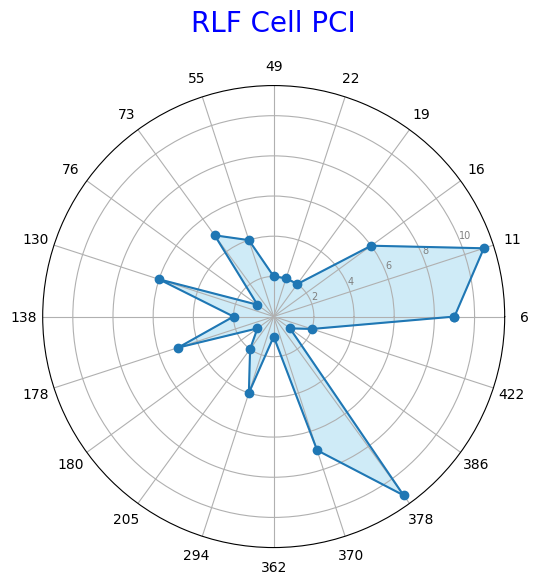

In [31]:
# 定義變數的名稱和數值
target = x2
categories = list(target.keys())
values = list(target.values())

# 計算角度
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# 使雷達圖封閉
values += values[:1]
angles += angles[:1]

# 畫圖
plt.figure(figsize=(6, 6))
plt.polar(angles, values, marker='o')
plt.fill(angles, values, color='skyblue', alpha=0.4)

# 設定標籤
plt.xticks(angles[:-1], categories)
plt.yticks(color='grey', size=7)
plt.title('RLF Cell PCI', size=20, color='b', y=1.1)

# 顯示圖表
plt.show()

# Signal Strength Analysis 

In [ ]:
rrc_file = '/home/wmnlab/D/database/2023-08-29/Modem_Control_Group/qc00/#01/data/diag_log_qc00_2023-08-29_15-25-58_rrc.csv'
ml1_file = '/home/wmnlab/D/database/2023-08-29/Modem_Control_Group/qc00/#01/data/diag_log_qc00_2023-08-29_15-25-58_ml1.csv'
nr_ml1_path = '/home/wmnlab/D/database/2023-08-29/Modem_Control_Group/qc00/#01/data/diag_log_qc00_2023-08-29_15-25-58_nr_ml1.csv'

In [ ]:
# Read csv with pandas
ml1_df = pd.read_csv(ml1_file)
ml1_df['Timestamp'] = pd.to_datetime(ml1_df['Timestamp'])
ml1_df['Timestamp'] = ml1_df['Timestamp'] + pd.Timedelta(hours=8)
ml1_df = ml1_df.astype({'PCI': str, 'EARFCN': str})

In [ ]:
# Read ml1 csv data
SS = namedtuple('SS', ['PCI', 'earfcn', 'RSRP', 'RSRQ', 'Timestamp'], defaults=['','',0,0,None])

Cells = {}
PCell = []
SCell1, SCell2, SCell3 = [], [], []

for i in range(len(ml1_df)):

    t = ml1_df['Timestamp'].iloc[i]
    serv_cell_idx = ml1_df['Serving Cell Index'].iloc[i]
    pci = ml1_df['PCI'].iloc[i]
    earfcn = ml1_df['EARFCN'].iloc[i]
    rsrp = ml1_df['RSRP(dBm)'].iloc[i]
    rsrq = ml1_df['RSRQ(dB)'].iloc[i]

    ss = SS(pci, earfcn, rsrp, rsrq, t)
    
    if serv_cell_idx == 'PCell':
        PCell.append(ss)
    elif serv_cell_idx == '1_SCell':
        SCell1.append(ss)
    elif serv_cell_idx == '2_SCell':
        SCell2.append(ss)
    elif serv_cell_idx == '(MI)Unknown':
        SCell3.append(ss)

    k = pci+' '+earfcn 
    if k in Cells.keys():
        Cells[k].append(ss)
    else:
        Cells[k] = [ss]

    # Cells
    num_neicells = ml1_df['Number of Neighbor Cells'].iloc[i]
    
    for j in np.arange(9, 9+num_neicells*3,3):
        pci = str(int(ml1_df.iloc[i][j]))
        rsrp = ml1_df.iloc[i][j+1]
        rsrq = ml1_df.iloc[i][j+2]
        ss = SS(pci, earfcn, rsrp, rsrq, t)
        k = pci+' '+earfcn 

        if k in Cells.keys():
            Cells[k].append(ss)
        else:
            Cells[k] = [ss]

In [ ]:
# Select plot target
targets = [PCell, SCell1, SCell2, SCell3]
labels = ['PCell', 'SCell1', 'SCell2', 'SCell3']

ts = []
rsrps = []
rsrqs = []

for target in targets:
 
    t = []
    rsrp, rsrq = [], []
 
    for ss in target:
        rsrp.append(ss.RSRP)
        rsrq.append(ss.RSRQ)
        t.append(ss.Timestamp)
    
    ts.append(t)
    rsrps.append(rsrp)
    rsrqs.append(rsrq)


# Given PCI and plot
targets = ['205 3050', '182 1750']

for target in targets:
    cell = Cells[target]
    t = []
    rsrp, rsrq = [], []
    for ss in cell:
        t.append(ss.Timestamp)
        rsrp.append(ss.RSRP)
        rsrq.append(ss.RSRQ)
    ts.append(t)
    rsrps.append(rsrp)
    rsrqs.append(rsrq)
    labels.append(target)

In [ ]:
# Select special event
hos = parse_mi_ho(rrc_file)
special_events = hos['RLF_II'] + hos['RLF_III']

In [ ]:
plt.figure(figsize=(15, 6))

for t, rsrp, rsrq, label in zip(ts, rsrps, rsrqs, labels):
    plt.plot(t, rsrp, marker='o', label=label)

for event in special_events:
    event_time = event.start
    plt.axvline(event_time, color='r', linestyle='--', linewidth=2)
    # plt.text(event_time, max(rsrps) + 1, 'Special Event', rotation=90, verticalalignment='bottom')

plt.xlabel('Timestamp')
plt.ylabel('RSRP(dbm)')
plt.title('Time Series with Special Events')
plt.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 创建数据
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# 创建第一个Y轴的图
fig, ax1 = plt.subplots()

# 绘制第一个数据集（使用蓝色）
ax1.set_xlabel('X')
ax1.set_ylabel('Y1', color='b')
ax1.plot(x, y1, color='b', label='Y1 Data')
ax1.tick_params(axis='y', labelcolor='b')

# 创建第二个Y轴的图
ax2 = ax1.twinx()
ax2.set_ylabel('Y2', color='r')
ax2.plot(x, y2, color='r', label='Y2 Data')
ax2.tick_params(axis='y', labelcolor='r')

# 添加图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 显示图形
plt.show()
